# Preliminaries

In [1]:
from gen_recover import *
import matplotlib.pyplot as plt
import math
%matplotlib inline
import numpy as np

In [2]:
# normalized objectives by empirical stdevs
def experiment_histog(moments, stdevs, m):
    k = len(moments)
    from cvxopt import matrix, solvers
    solvers.options['show_progress'] = False
    A = np.zeros((m + 2 * k + 3, m + k + 1))
    B = np.zeros(m + 2 * k + 3)
    C = np.zeros(m + k + 1)
    # set C (optimization)
    for i in xrange(m + 1, m + k + 1):
        C[i] = 1.0
    # set B (constraints)
    B[0] = 1.0
    B[1] = -1.0
    for i in xrange(k):
        B[m + 3 + (2 * i)] = moments[i]
        B[m + 3 + (2 * i) + 1] = -1.0 * moments[i]
    # set A (linear coefficients)
    for i in xrange(m + 1):
        A[0][i] = 1.0
        A[1][i] = -1.0
        A[2 + i][i] = -1.0

    for j in xrange(k):
        A[m + 3 + (2 * j)][m + 1 + j] = -1.0
        A[m + 3 + (2 * j) + 1][m + 1 + j] = -1.0
        for i in xrange(m + 1):
            A[m + 3 + (2 * j)][i] = (((float(i) / float(m))) ** (j + 1))
            A[m + 3 + (2 * j) + 1][i] = (-1.0 * ((float(i) / float(m))) ** (j + 1))
    # print A
    G = matrix(np.ndarray.tolist(np.transpose(A)))
    h = matrix(np.ndarray.tolist(B))
    weights = np.zeros(m + k + 1)
    for i in xrange(k):
        weights[m + i + 1] = 1.0 / (stdevs[i] ** 2)
    P = matrix(np.ndarray.tolist(np.diag(weights)))
    q = matrix(np.ndarray.tolist(np.zeros(m + k + 1)))
    # print B
    # print C
    #sol = solvers.lp(matrix(np.ndarray.tolist(C)), matrix(np.ndarray.tolist(A)), matrix(np.ndarray.tolist(B)))
    sol = solvers.qp(P, q, G, h)
    #print np.dot(C, np.asarray(sol['x']))
    return sol['x']

In [3]:
# normalized objectives by empirical stdevs
# TODO: some of the weights are negative...??
def constrained_experiment_histog(moments, stdevs, m, limit):
    k = len(moments)
    from cvxopt import matrix, solvers
    A = np.zeros((2 * m + 2 * k + 4, m + k + 1))
    B = np.zeros(2 * m + 2 * k + 4)
    C = np.zeros(m + k + 1)
    # set C (optimization)
    for i in xrange(m + 1, m + k + 1):
        C[i] = 1.0
    # set B (constraints)
    B[0] = 1.0
    B[1] = -1.0
    for i in xrange(m + 1):
        B[m + 3 + i] = limit
    for i in xrange(k):
        B[(2 * m) + 4 + (2 * i)] = moments[i] / stdevs[i]
        B[(2 * m) + 4 + (2 * i) + 1] = -1.0 * moments[i] / stdevs[i]
    # set A (linear coefficients)
    for i in xrange(m + 1):
        A[0][i] = 1.0
        A[1][i] = -1.0
        A[2 + i][i] = -1.0
        A[m + 3 + i][i] = 1.0
    for j in xrange(k):
        A[(2 * m) + 4 + (2 * j)][m + 1 + j] = -1.0
        A[(2 * m) + 4 + (2 * j) + 1][m + 1 + j] = -1.0
        for i in xrange(m + 1):
            A[(2 * m) + 4 + (2 * j)][i] = (((float(i) / float(m))) ** (j + 1)) / stdevs[j]
            A[(2 * m) + 4 + (2 * j) + 1][i] = (-1.0 * ((float(i) / float(m))) ** (j + 1)) / stdevs[j]
    # print A
    A = np.transpose(A)
    # print B
    # print C
    sol = solvers.lp(matrix(np.ndarray.tolist(C)), matrix(np.ndarray.tolist(A)), matrix(np.ndarray.tolist(B)))
    print np.dot(C, np.asarray(sol['x']))
    return sol['x']

In [4]:
def moments_stdevs(samples, k):
    n, s = samples.shape
    counts = np.sum(samples, axis=1)
    mom_dist = [np.asarray([float(comb(counts[j], i)) / float(comb(s, i)) for j in xrange(n)]) for i in xrange(1, k + 1)]
    moments = [np.mean(mom) for mom in mom_dist]
    stdevs = [np.std(mom) / math.sqrt(n) for mom in mom_dist]
    return moments, stdevs

def moments_stdevs_stacked(samples, k):
    moments = []
    stdevs = []
    for i in xrange(1, k + 1):
        mom_dist = np.asarray([float(comb(row[1], i)) / float(comb(row[0], i)) for row in samples if (row[0] >= i)])
        moments.append(np.mean(mom_dist))
        stdevs.append(np.std(mom_dist) / math.sqrt(len(mom_dist)))
    return moments, stdevs

def cdf(mesh):
    return np.cumsum(mesh)

def cdf_distro(sample_ps, granularity):
    ss = sorted(sample_ps)
    cdf = np.zeros(granularity + 1)
    for p in ss:
        cdf[int(p * granularity) + 1 : granularity + 1] += np.ones(granularity - int(p * granularity))
    cdf /= float(len(ss))
    return cdf

def pdf_distro(sample_ps, granularity):
    ss = sorted(sample_ps)
    cdf = np.zeros(granularity + 1)
    for p in ss:
        cdf[int(p * granularity) + 1] += 1
    cdf /= float(len(ss))
    return cdf

def isint(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
    
def cdf_dist(c0, c1):
    return np.sum(np.absolute(c0 - c1)) / float(len(c0) - 1)

# Flight data processing

In [5]:
import numpy as np
flights = np.loadtxt("Flights/flights.csv", skiprows=1, delimiter=',', dtype='str')

In [6]:
flight_info = {}
for row in flights:
    identifier = (row[4], row[5], row[7], row[8])
    if isint(row[11]) and isint(row[22]):
        if identifier not in flight_info:
            flight_info[identifier] = [[int(row[11]), int(row[22])]]
        else:
            flight_info[identifier].append([int(row[11]), int(row[22])])

In [7]:
lengths = [len(flight_info[key]) for key in flight_info.keys()]
flight_info_filter = {key: flight_info[key] for key in flight_info if (len(flight_info[key]) > 50)}

In [8]:
agg_flight_info = {}
for row in flights:
    identifier = (row[4], row[5])
    if isint(row[11]) and isint(row[22]):
        if identifier not in agg_flight_info:
            agg_flight_info[identifier] = [(int(row[11]), int(row[22]))]
        else:
            agg_flight_info[identifier].append((int(row[11]), int(row[22])))

In [9]:
agg_lengths = [len(agg_flight_info[key]) for key in agg_flight_info.keys()]

# Flight experiment

In [10]:
# degrees of freedom:
# 1. threshold 2. sample size 3. number of moments taken
threshold = 15
def threshold_eval(x):
    return int(x >= threshold)

npte = np.vectorize(threshold_eval)
ground_truth = {key : np.mean(npte(np.asarray(flight_info_filter[key])), axis=0) for key in flight_info_filter}

In [11]:
ground_truth_departure_ps = [ground_truth[key][0] for key in ground_truth]
ground_truth_arrival_ps = [ground_truth[key][1] for key in ground_truth]

In [12]:
flight_info_filter_samples = {key : npte(np.asarray(flight_info_filter[key])[np.random.randint(len(flight_info_filter[key]), size=10)]) for key in flight_info_filter}
names = ground_truth.keys()
stacked_samples_departure = np.asarray([[10, np.sum(flight_info_filter_samples[key], axis=0)[0]] for key in names])
departure_sample_empirical_p = np.asarray([(float(row[1]) / float(row[0])) for row in stacked_samples_departure])
stacked_samples_arrival = np.asarray([[10, np.sum(flight_info_filter_samples[key], axis=0)[1]] for key in names])
arrival_sample_empirical_p = np.asarray([(float(row[1]) / float(row[0])) for row in stacked_samples_arrival])

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
0.00585565653208
0.0451009103196


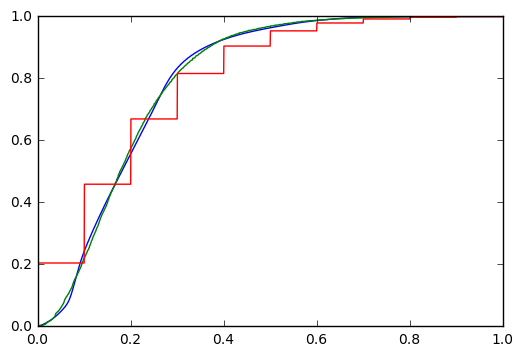

In [14]:
# qp version
n = len(stacked_samples_departure)
total_cdf = np.zeros((2001, 1))
for i in xrange(10):
    print "iteration " + str(i)
    m, s = moments_stdevs_stacked(stacked_samples_departure[np.random.randint(n, size=n/4)], 6)
    nonzero = len(m)
    if 0.0 in m:
        nonzero = m.index(0.0)
    x = experiment_histog(m[:nonzero], s[:nonzero], 2000)
    total_cdf += np.asarray(x[:2001])
total_cdf /= 10.0
y_mesh = cdf(total_cdf)

x_mesh = np.linspace(0, 1, 2001)

axes = plt.gca()
axes.set_ylim([0.0, 1.0])
plt.plot(x_mesh, y_mesh)
plt.plot(x_mesh, cdf_distro(ground_truth_departure_ps, 2000))
plt.plot(x_mesh, cdf_distro(departure_sample_empirical_p, 2000))
print cdf_dist(y_mesh, cdf_distro(ground_truth_departure_ps, 2000))
print cdf_dist(cdf_distro(departure_sample_empirical_p, 2000), cdf_distro(ground_truth_departure_ps, 2000))

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
0.0108598576002
0.0451009103196


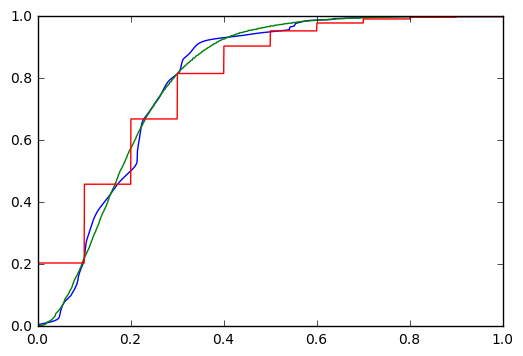

In [15]:
# qp version
n = len(stacked_samples_departure)
total_cdf = np.zeros((2001, 1))
for i in xrange(10):
    print "iteration " + str(i)
    m, s = moments_stdevs_stacked(stacked_samples_departure[np.random.randint(n, size=n/4)], 10)
    nonzero = len(m)
    if 0.0 in m:
        nonzero = m.index(0.0)
    x = experiment_histog(m[:nonzero], s[:nonzero], 2000)
    total_cdf += np.asarray(x[:2001])
total_cdf /= 10.0
y_mesh = cdf(total_cdf)

x_mesh = np.linspace(0, 1, 2001)

axes = plt.gca()
axes.set_ylim([0.0, 1.0])
plt.plot(x_mesh, y_mesh)
plt.plot(x_mesh, cdf_distro(ground_truth_departure_ps, 2000))
plt.plot(x_mesh, cdf_distro(departure_sample_empirical_p, 2000))
print cdf_dist(y_mesh, cdf_distro(ground_truth_departure_ps, 2000))
print cdf_dist(cdf_distro(departure_sample_empirical_p, 2000), cdf_distro(ground_truth_departure_ps, 2000))